<a href="https://colab.research.google.com/github/saarangmahun/comp215/blob/main/labs/lab04-more_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COMP 215 - LAB 4
----------------
#### Name(s):
#### Date:

By the end of this lab you should be able to:
  * use composition and inheritance in a `class` to categorize related information


During this lab, you will be introduced to the following:
  * something, something



## Near Earth Objects (with more classes)

We'll continue working with Near Earth Object data using NASA's API: https://api.nasa.gov/.  In Lab 3 we defined an Asteroid class that contained a simple data structure.  In this lab, we will be Here's a brief review from Lab 2 on how to use the API.  

In [ ]:
# import necessary modules
import datetime, json, requests
from pprint import pprint

### Review: make an API query

Here's a query that gets the record for a single NEO that recently passed by.

In [ ]:
#API_KEY = 'DEMO_KEY'
API_KEY = 'QMU73gySBTeUk6FVRje8eMwNOFfI1FZOwRtlf0Xo'

def get_neos(start_date):
    """ Return a list of NEO for the week starting at start_date """
    url = f'https://api.nasa.gov/neo/rest/v1/feed?start_date={start_date}&api_key={API_KEY}'
    # last weeks data
    response = requests.request("GET", url, headers={}, data={})
    data = json.loads(response.text)
    #pprint(data)
    print(f'{data["element_count"]} Near Earth Objects found for week of {start_date}')
    return [neo for dated_records in data['near_earth_objects'].values() for neo in dated_records ]

def get_neo(id):
    """ Return a NEO record for the given id """
    url = f'https://api.nasa.gov/neo/rest/v1/neo/{id}?api_key={API_KEY}'
    response = requests.request("GET", url, headers={}, data={})
    return json.loads(response.text)

week_start = '2023-01-15'
neos = get_neos(week_start)
assert len(neos) > 0, f'Oh oh!  No NEOs found for {week_start}'
neo = get_neo(neos[-1]['id'])
print(f"Record for NEO ID {neos[-1]['id']} is:")
pprint(neo)

## Exercise 1: Define a CloseApproach class

Each NEO record comes with a list of `close_approach_data`, where each record in this list represents a single “close approach” to another orbiting body.
1. Develop a class named `CloseApproach` to represent a single close approach record.  State variables are

        neo (refrence to related NEO object)
        orbiting body (str)
        approach date (datetime object!)
        miss distance (float - choose units, document it, and be consistent!)
        relative velocity (ditto)
  
2. Define a "Factory" class method to construct a `CloseApproach` object from one close approach data record (a dictionary object). This method takes a `neo` object as input for the NEO to which the close approach data belongs. Remember to parse the date/time string into a datetime object.

In [10]:
import datetime
import json
import requests
from pprint import pprint

API_KEY = 'HC89pggELzLAkJC7wrSuf1XUZ1Uz2NxKOtjzhBUf'

def get_neos(start_date, end_date):
    url = f'https://api.nasa.gov/neo/rest/v1/feed?start_date={start_date}&end_date={end_date}&api_key={API_KEY}'
    response = requests.get(url)
    data = response.json()
    print(f'{data["element_count"]} NEOs found for period {start_date} to {end_date}')
    return [neo for day in data['near_earth_objects'].values() for neo in day]

class CloseApproach:
    def __init__(self, neo, orbiting_body, approach_date, miss_distance, relative_velocity):
        self.neo = neo
        self.orbiting_body = orbiting_body
        self.approach_date = approach_date
        self.miss_distance = miss_distance
        self.relative_velocity = relative_velocity

    @classmethod
    def from_dict(cls, approach_data, neo):
        date_str = approach_data.get("close_approach_date")
        approach_date = datetime.datetime.strptime(date_str, "%Y-%m-%d")
        orbiting_body = approach_data.get("orbiting_body")
        miss_distance = float(approach_data["miss_distance"]["kilometers"])
        relative_velocity = float(approach_data["relative_velocity"]["kilometers_per_second"])
        return cls(neo, orbiting_body, approach_date, miss_distance, relative_velocity)

    def __repr__(self):
        neo_id = self.neo.get('id', 'N/A') if isinstance(self.neo, dict) else self.neo
        return (f"CloseApproach(neo={neo_id}, orbiting_body='{self.orbiting_body}', "
                f"approach_date={self.approach_date.strftime('%Y-%m-%d')}, "
                f"miss_distance={self.miss_distance} km, "
                f"relative_velocity={self.relative_velocity} km/s)")

if __name__ == '__main__':
    start_date = '2025-02-02'
    end_date = '2025-02-08'
    neos = get_neos(start_date, end_date)

    if neos:
        # Pick a sample NEO and display its raw data.
        sample_neo = neos[0]
        print("\nSample NEO data:")
        pprint(sample_neo)

        # Use the first close approach record from the sample NEO.
        if sample_neo.get("close_approach_data"):
            ca_data = sample_neo["close_approach_data"][0]
            ca_obj = CloseApproach.from_dict(ca_data, sample_neo)
            print("\nSample CloseApproach object:")
            print(ca_obj)
        else:
            print("No close approach data available for the sample NEO.")
    else:
        print("No NEO data available.")


86 NEOs found for period 2025-02-02 to 2025-02-08

Sample NEO data:
{'absolute_magnitude_h': 21.67,
 'close_approach_data': [{'close_approach_date': '2025-02-08',
                          'close_approach_date_full': '2025-Feb-08 18:00',
                          'epoch_date_close_approach': 1739037600000,
                          'miss_distance': {'astronomical': '0.30632482',
                                            'kilometers': '45825540.6001334',
                                            'lunar': '119.16035498',
                                            'miles': '28474670.54090492'},
                          'orbiting_body': 'Earth',
                          'relative_velocity': {'kilometers_per_hour': '65157.477621291',
                                                'kilometers_per_second': '18.0992993392',
                                                'miles_per_hour': '40486.3226919627'}}],
 'estimated_diameter': {'feet': {'estimated_diameter_max': 903.7015558997,


## Exercise 2: Add list of CloseApproach objects to the Asteroid

Define an `Asteroid` class, like you did in Lab 3, but give the `Asteroid` list of “close approaches”.  This is called *composition* because each Asteroid object will be *composed* of CloseApproach objects (plus some other things).  There is bit of a catch-22 here because we need the `Asteroid` to construct the `CloseApproach` objects. The first two steps deal with that:

1. Add an instance variable to your Asteroid class with a default value of an empty list:

    ```
    close_approaches:list = []
    ```
      
2. In the Asteroid `from_NEO` factory, use a list comprehension to build the list of `CloseApproach` objects for the Asteroid instance, and then set the instance's `close_approaches` variable before returning it. Setting the value of an object's instance variables from outside the class is generally frowned upon - this is why we make the factory a method of the class itself.

3. Add a method to `Asteroid` to return the `CloseApproach` object for the nearest miss (ie. smallest `missed_distance`):
    ```
    def nearest_miss(self):
        ...
    ```

4. Add a method to the Asteroid class, `closest_earth_approach`, that returns the CloseApproach object that represents the closest approach the Asteroid makes to Earth.
    ```
    def closest_earth_approach(self):
        ...
    ```

Write some test code to demonstrate these new features.

In [9]:
import datetime
import json
import requests
from pprint import pprint

API_KEY = 'HC89pggELzLAkJC7wrSuf1XUZ1Uz2NxKOtjzhBUf'

def get_neos(start_date, end_date):
    url = f'https://api.nasa.gov/neo/rest/v1/feed?start_date={start_date}&end_date={end_date}&api_key={API_KEY}'
    response = requests.get(url)
    data = response.json()
    print(f'{data["element_count"]} NEOs found for period {start_date} to {end_date}')
    return [neo for daily in data['near_earth_objects'].values() for neo in daily]

def get_neo(neo_id):
    url = f'https://api.nasa.gov/neo/rest/v1/neo/{neo_id}?api_key={API_KEY}'
    response = requests.get(url)
    return response.json()

class CloseApproach:
    def __init__(self, neo, orbiting_body, approach_date, miss_distance, relative_velocity):
        self.neo = neo
        self.orbiting_body = orbiting_body
        self.approach_date = approach_date
        self.miss_distance = miss_distance
        self.relative_velocity = relative_velocity

    @classmethod
    def from_dict(cls, approach_data, neo):
        date_str = approach_data.get("close_approach_date")
        approach_date = datetime.datetime.strptime(date_str, "%Y-%m-%d")
        orbiting_body = approach_data.get("orbiting_body")
        miss_distance = float(approach_data["miss_distance"]["kilometers"])
        relative_velocity = float(approach_data["relative_velocity"]["kilometers_per_second"])
        return cls(neo, orbiting_body, approach_date, miss_distance, relative_velocity)

    def __repr__(self):
        neo_id = self.neo.get('id', 'N/A') if isinstance(self.neo, dict) else self.neo
        return (f"CloseApproach(neo={neo_id}, orbiting_body='{self.orbiting_body}', "
                f"approach_date={self.approach_date.strftime('%Y-%m-%d')}, "
                f"miss_distance={self.miss_distance} km, "
                f"relative_velocity={self.relative_velocity} km/s)")

class Asteroid:
    def __init__(self, neo_id, name, is_hazardous, close_approaches=None):
        self.id = neo_id
        self.name = name
        self.is_hazardous = is_hazardous
        self.close_approaches = close_approaches if close_approaches is not None else []

    @classmethod
    def from_neo(cls, neo_dict):
        neo_id = neo_dict.get("id")
        name = neo_dict.get("name")
        is_hazardous = neo_dict.get("is_potentially_hazardous_asteroid", False)
        asteroid = cls(neo_id, name, is_hazardous)
        asteroid.close_approaches = [
            CloseApproach.from_dict(approach, neo_dict)
            for approach in neo_dict.get("close_approach_data", [])
        ]
        return asteroid

    def nearest_miss(self):
        return min(self.close_approaches, key=lambda ca: ca.miss_distance) if self.close_approaches else None

    def closest_earth_approach(self):
        earth_approaches = [ca for ca in self.close_approaches if ca.orbiting_body == "Earth"]
        return min(earth_approaches, key=lambda ca: ca.miss_distance) if earth_approaches else None

    def __repr__(self):
        return (f"Asteroid(id={self.id}, name='{self.name}', hazardous={self.is_hazardous}, "
                f"close_approaches={len(self.close_approaches)})")

if __name__ == '__main__':
    start_date = '2025-02-02'
    end_date = '2025-02-08'
    try:
        neos = get_neos(start_date, end_date)
    except Exception as e:
        print("Error fetching NEO data:", e)
        neos = []

    if neos:
        pprint(neos[0])
        neo_id = neos[0]['id']
        neo_details = get_neo(neo_id)
        pprint(neo_details)
        asteroid = Asteroid.from_neo(neo_details)
        print("\nAsteroid object:")
        print(asteroid)
        print("\nClose approach records:")
        for ca in asteroid.close_approaches:
            print(ca)
        nm = asteroid.nearest_miss()
        print("\nNearest miss:", nm)
        cea = asteroid.closest_earth_approach()
        print("Closest Earth approach:", cea)
    else:
        print("No NEO data available.")


86 NEOs found for period 2025-02-02 to 2025-02-08
{'absolute_magnitude_h': 21.67,
 'close_approach_data': [{'close_approach_date': '2025-02-08',
                          'close_approach_date_full': '2025-Feb-08 18:00',
                          'epoch_date_close_approach': 1739037600000,
                          'miss_distance': {'astronomical': '0.30632482',
                                            'kilometers': '45825540.6001334',
                                            'lunar': '119.16035498',
                                            'miles': '28474670.54090492'},
                          'orbiting_body': 'Earth',
                          'relative_velocity': {'kilometers_per_hour': '65157.477621291',
                                                'kilometers_per_second': '18.0992993392',
                                                'miles_per_hour': '40486.3226919627'}}],
 'estimated_diameter': {'feet': {'estimated_diameter_max': 903.7015558997,
                  

## Exercise 3: Plot the Closest Approaches

Write a function that takes an Asteroid object as a parameter and makes a timeline plot of close approaches.  You may wish to use the `matplotlib.pyplot` `plot` object.  Here is an example of a timeline plot for the asteroid with neo id '54339874'

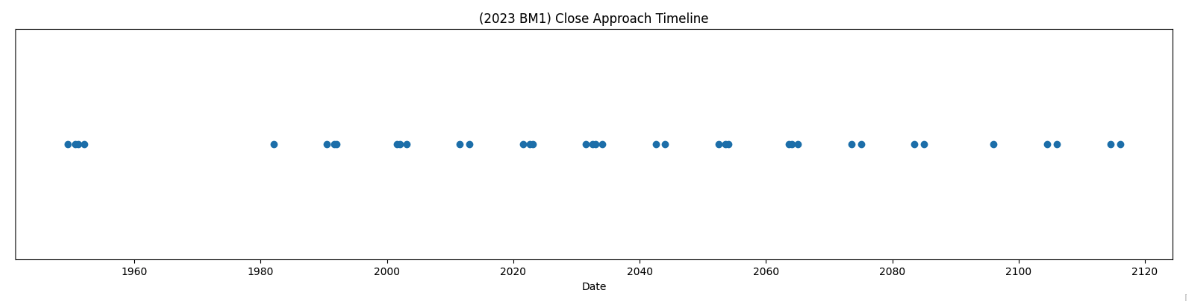

86 NEOs found for period 2025-02-02 to 2025-02-08

Asteroid object:
Asteroid(id=3742877, name='(2016 CE137)', hazardous=False, close_approaches=20)

Close approach records:
CloseApproach(neo=3742877, orbiting_body='Earth', approach_date=1903-02-10, miss_distance=53331961.153476685 km, relative_velocity=19.2931948238 km/s)
CloseApproach(neo=3742877, orbiting_body='Earth', approach_date=1937-02-13, miss_distance=72854318.75049798 km, relative_velocity=14.3925934005 km/s)
CloseApproach(neo=3742877, orbiting_body='Earth', approach_date=1946-02-08, miss_distance=49446565.82487837 km, relative_velocity=14.6637343825 km/s)
CloseApproach(neo=3742877, orbiting_body='Earth', approach_date=1955-02-07, miss_distance=37450663.571221605 km, relative_velocity=15.9213426337 km/s)
CloseApproach(neo=3742877, orbiting_body='Earth', approach_date=1964-02-09, miss_distance=48622881.388797924 km, relative_velocity=18.5406086947 km/s)
CloseApproach(neo=3742877, orbiting_body='Earth', approach_date=1973-02-13

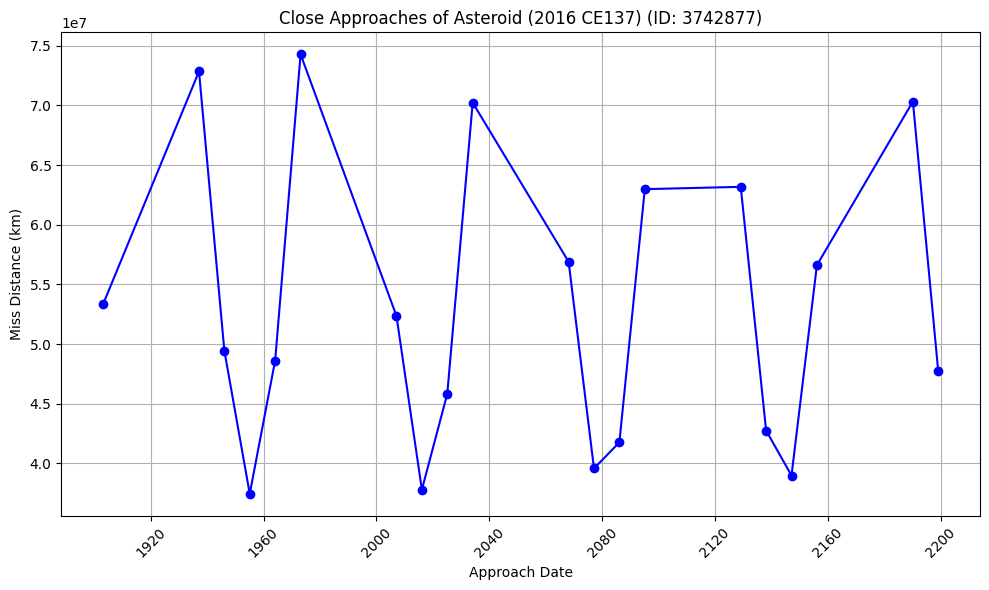

In [11]:
import matplotlib.pyplot as plt
import datetime

def plot_close_approaches(asteroid):
    if not asteroid.close_approaches:
        print("No close approach data available for this asteroid.")
        return

    dates = [ca.approach_date for ca in asteroid.close_approaches]
    miss_distances = [ca.miss_distance for ca in asteroid.close_approaches]

    plt.figure(figsize=(10, 6))
    plt.plot(dates, miss_distances, marker='o', linestyle='-', color='b')
    plt.title(f"Close Approaches of Asteroid {asteroid.name} (ID: {asteroid.id})")
    plt.xlabel("Approach Date")
    plt.ylabel("Miss Distance (km)")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    start_date = '2025-02-02'
    end_date = '2025-02-08'
    try:
        neos = get_neos(start_date, end_date)
    except Exception as e:
        print("Error fetching NEO data:", e)
        neos = []

    if neos:
        neo_id = neos[0]['id']
        neo_details = get_neo(neo_id)
        asteroid = Asteroid.from_neo(neo_details)
        print("\nAsteroid object:")
        print(asteroid)
        print("\nClose approach records:")
        for ca in asteroid.close_approaches:
            print(ca)

        plot_close_approaches(asteroid)
    else:
        print("No NEO data available.")

## Challenge - Take your skills to the next level...

 With these data structures in place, we can now start answering all kinds of interesting questions about a single Asteroid or a set of Asteroids.  
Here’s a couple ideas to try:



* write a **function** named `most_dangerous_approach`, that takes a date range and returns a single “potentially hazardous” Asteroid object that makes the closest approach to Earth in within that range.  Your algorithm will ultimately need to:
    * grab the list of NEO’s for the given date range;
    * use a list comprehension to build the list of Asteroid objects for the NEO’s returned
    * use a list comprehension to filter  potentially hazardous Asteroids only;
    * use a list comprehension to map each Asteroid to its  closest_earth_approach
    * apply Python’s min function to identify the Asteroid with the closest_earth_approach

You may want to decompose some of these steps into smaller functions.
* add a method to the Asteroid class, estimated_mass, that computes an estimate of the Asteroid’s mass based on its diameter.  This is a model – state your assumptions.
* add a method to the CloseApproach class, impact_force,  that estimates the force of impact if the Asteroid hit the orbiting object.  Again, this is a model, state your assumptions.

In [ ]:
# Ex. 5 (challenge) your code here